In [84]:
## Import required Python modules
%matplotlib inline
import matplotlib.pyplot as plt
## Customising the font size of figures
plt.rcParams.update({'font.size': 14})

<div class="container-fluid">
    <div class="row">
        <div class="col-md-8" align="center">
            <h1>PHYS 10792: Introduction to Data Science</h1>
        </div>
        <div class="col-md-3">
            <img align='center' style="border-width:0" src="images/UoM_logo.png"/>
        </div>
    </div>
</div>

<div class="container-fluid">
    <div class="row">
        <div class="col-md-2" align="right">
            <b>Course instructors:&nbsp;&nbsp;</b>
        </div>
        <div class="col-md-9" align="left">
            <a href="http://www.ajmarkwick.net/">Dr. Andrew Markwick</a> - Twitter <a href="https://twitter.com/AndrewMarkwick">@AndrewMarkwick</a><br>
            <a href="www.oms-lab.org">Dr. Patrick Parkinson</a>
        </div>
    </div>
</div>

# Chapter 12 - Real world example

In this section, we will work through a "real-world" example of some of the techniques we've introduced so far.

Specifically, we will use the rainfall data for Northwest England, available from [The Met Office](https://www.metoffice.gov.uk/research/climate/maps-and-data/uk-and-regional-series).

## Load Python

We require a number of standard python packages to manage the datasets.

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FormatStrFormatter

# Set the aesthetics for plots
plt.style.use('seaborn-v0_8')
sns.set_context("notebook", font_scale=1.2)

# For reproducibility
np.random.seed(42)

## 1. Data loading and preparation

First step is to load the data, and convert it from year-month format into a month format.

In [86]:
df_raw = pd.read_csv('England_NW_and_N_Wales.txt', sep=r'\s+', skiprows=5, index_col=0)

# Melt the dataframe to get it in a format with monthly data in rows
# Year is the index, and each month is a column (in three letter abbreviation)
df = df_raw.melt(ignore_index=False)
# Reset the index to get a new column for the year
df.reset_index(inplace=True)
# Rename the columns for clarity
df.columns = ['Year', 'Month', 'Rainfall']

# Filter out non-standard month values
valid_months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
df = df[df['Month'].isin(valid_months)]

# Convert the month names to numbers
df['MonthNum'] = pd.to_datetime(df['Month'], format='%b').dt.month
# Rename "Month" to "MonthName" for clarity
df.rename(columns={'Month': 'MonthName'}, inplace=True)
# Create a new column for the date
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['MonthNum'].astype(str), format='%Y-%m')
# Drop the original Year and Month columns
df.drop(columns=['MonthNum'], inplace=True)
# Set the date as the index
df.set_index('Date', inplace=True)

# Ensure Rainfall column is numeric and handle missing values
df['Rainfall'] = pd.to_numeric(df['Rainfall'], errors='coerce')
df.dropna(subset=['Rainfall'], inplace=True)

# Sort the dataframe by date
df.sort_index(inplace=True)
# Reset the index to get a new column for the date
df.reset_index(inplace=True)
# Create a new column for standard deviation
df['StdDev'] = (df['Rainfall'] * 0.3).round()

# Calculate annual rainfall
annual_df = df.groupby('Year')['Rainfall'].sum().reset_index()

print(df.head())

        Date  Year MonthName  Rainfall  StdDev
0 1836-01-01  1836       jan     108.5    33.0
1 1836-02-01  1836       feb      82.7    25.0
2 1836-03-01  1836       mar     161.5    48.0
3 1836-04-01  1836       apr      88.6    27.0
4 1836-05-01  1836       may       4.6     1.0


## 2. Exploratory data analysis

We start by looking at some basic data about the numbers we have, to help to understand the "scale" of the measurements.

### 2.1 Basic summary statistics

How many data points? What is the average, standard deviation etc?

In [87]:
print("Dataset Summary Statistics:")
summary_stats = df['Rainfall'].describe()
print(summary_stats)

Dataset Summary Statistics:
count    2273.000000
mean      103.940211
std        49.532260
min         4.200000
25%        67.300000
50%        98.300000
75%       135.900000
max       362.900000
Name: Rainfall, dtype: float64


### 2.2 Visualize the data distribution

The most basic plot we could do is a histogram of the measurements.

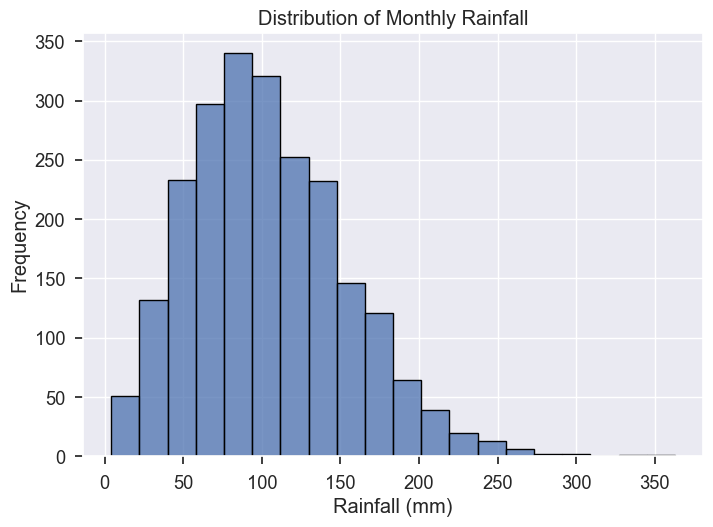

In [88]:
sns.histplot(df['Rainfall'], bins=20)
plt.title('Distribution of Monthly Rainfall')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Frequency');

### 2.3 Time series visualization

Next, we can look at how the data has varied over time. Notice how the variation changes, and that there is an apparent slope over time.

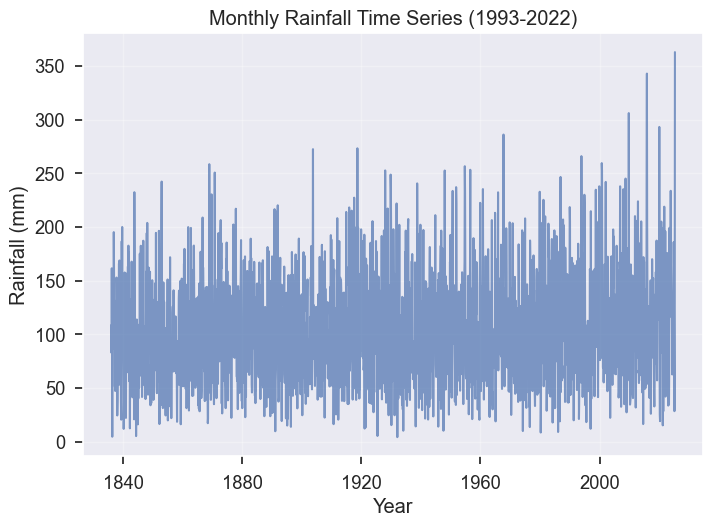

In [89]:
plt.plot(df['Date'], df['Rainfall'], marker='', linestyle='-', alpha=0.7)
plt.title('Monthly Rainfall Time Series (1993-2022)')
plt.xlabel('Year')
plt.ylabel('Rainfall (mm)')
plt.grid(True, alpha=0.3)

### 2.4 Seasonal patterns

We expect a 12-month periodicity in the data, and can look at this by grouping by month namme.

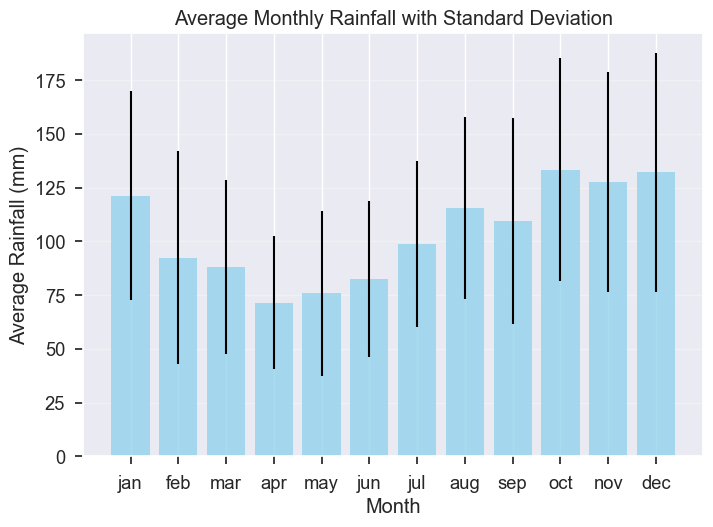

In [90]:
# Group by month and calculate the mean and standard deviation
monthly_avg = df.groupby('MonthName')['Rainfall'].mean()
monthly_std = df.groupby('MonthName')['Rainfall'].std()

# Sort the months in the correct order
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
monthly_avg = monthly_avg.reindex(month_order)
monthly_std = monthly_std.reindex(month_order)

# Plot the average monthly rainfall with error bars for standard deviation
plt.bar(monthly_avg.index, monthly_avg.values, yerr=monthly_std.values, alpha=0.7, capsize=5, color='skyblue')
plt.title('Average Monthly Rainfall with Standard Deviation')
plt.xlabel('Month')
plt.ylabel('Average Rainfall (mm)')
plt.grid(True, alpha=0.3, axis='y')

## 3. Probability Distribution and Parameter Estimation

We need to decide what kind of distribution best explains our data. This will allow us  We can consider normal, gamma, log-normal, Poissonian, uniform etc.

Which might work well?

- **Normal Distribution**: Assumes data is symmetrically distributed around the mean. Good for datasets with a bell-shaped curve, but bad if the data is skewed or has outliers.
- **Gamma Distribution**: Suitable for modeling skewed data with a lower bound at zero. *Good for rainfall data, which is often positively skewed and non-negative.*
- **Log-Normal Distribution**: Models data that is positively skewed and multiplicative. *Good for rainfall data, as it can handle large variations and skewness.*
- **Cauchy Distribution**: Known for its heavy tails and undefined mean and variance. *Bad for rainfall data, as it can produce extreme values and lacks a central tendency, making it unsuitable for modeling typical rainfall patterns.*
-- **Exponential Distribution**: Models the time between events in a Poisson process, with a constant hazard rate. *Good for modeling the time between rainfall events, but bad for continuous rainfall amounts, as it assumes a constant rate and lacks the flexibility to capture varying intensities.*
- **Uniform Distribution**: Assumes all values within a range are equally likely. *Bad for rainfall data, which typically has a more complex distribution pattern.*

To decide which distribution is most realistic, we can fit them all to the dataset.

### 3.1. Fit different distributions

Best fitting distribution: Gamma
Parameters: (np.float64(6.9506090453957174), np.float64(-27.675411690662322), np.float64(18.93583937410142))


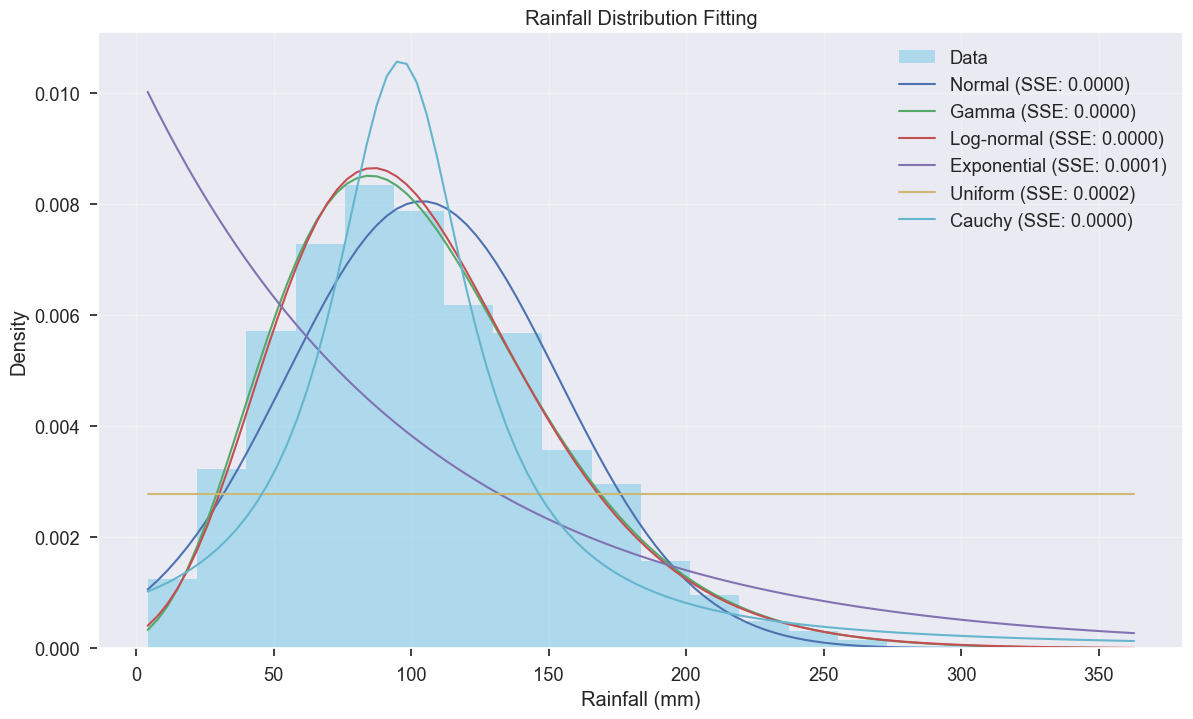

In [91]:
rainfall_data = df['Rainfall'].values

# Define the distributions to test
distributions = [
    stats.norm,      # Normal distribution
    stats.gamma,     # Gamma distribution (often used for rainfall)
    stats.lognorm,   # Log-normal distribution
    stats.expon,     # Exponential distribution (not typically used for rainfall)
    stats.uniform,   # Uniform distribution (not typically used for rainfall)
    stats.cauchy,    # Cauchy distribution (not typically used for rainfall)

]

dist_names = ['Normal', 'Gamma', 'Log-normal', 'Exponential', 'Uniform', 'Cauchy']
dist_params = []
dist_sse = []  # Sum of squared errors

x = np.linspace(min(rainfall_data), max(rainfall_data), 100)
hist_data, bins = np.histogram(rainfall_data, bins=20, density=True)
bin_centers = (bins[1:] + bins[:-1]) / 2

plt.figure(figsize=(14, 8))
plt.hist(rainfall_data, bins=20, density=True, alpha=0.6, color='skyblue', label='Data')

for i, dist in enumerate(distributions):
    # Fit distribution
    params = dist.fit(rainfall_data)
    dist_params.append(params)
    
    # Calculate goodness of fit
    pdf = dist.pdf(bin_centers, *params[:-2], loc=params[-2], scale=params[-1])
    sse = np.sum((pdf - hist_data)**2)
    dist_sse.append(sse)
    
    # Plot PDF
    pdf_fitted = dist.pdf(x, *params[:-2], loc=params[-2], scale=params[-1])
    plt.plot(x, pdf_fitted, label=f'{dist_names[i]} (SSE: {sse:.4f})')

plt.title('Rainfall Distribution Fitting')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

# Find the best fitting distribution
best_dist_idx = np.argmin(dist_sse)
print(f"Best fitting distribution: {dist_names[best_dist_idx]}")
print(f"Parameters: {dist_params[best_dist_idx]}")

## 4. Hypothesis testing: Is there a climate trend?

Having look at the data, trends and distribution, we can define a hypothesis test. In this case, we can ask - is there a trend in rainfall over time?

As a one-sided test, this would become - is rainfall increasing over time?

We express this as a *hypothesis test*:
- **Null Hypothesis**: Rainfall does not vary with time
- **Alternative Hypothesis**: Rainfall increases with time

To do this test, we need to create a model, fit parameters, measure their confidence intervals, and use a statistical test.

### 4.1 Linear regession

We make use of the "LinearRegression" fitter from the sklearn package.

In [92]:
# Extract the annual rainfall from the dataset
X = annual_df['Year'].values.reshape(-1, 1)
y = annual_df['Rainfall'].values

# Fit linear regression
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

### 4.2 Calculate confidence intervals

Confidence intervals on the fit parameters can be calculated using the mean-squared error between the model and the data.

We first calculate the residuals between the model and the data. We can calculate the standard error from this.

The t-test is a metric that allows us to calculate the confidence bands. We use the command ppf - percentage point function - which provides the confidence interval for the 0.975 point with n-p-1 degrees of freedom.

This value can then be multiplied by the standard error to scale it.

In [93]:
# Calculate confidence intervals
n = len(X)
p = 1  # Number of parameters (slope only)
y_err = y - y_pred
s_err = np.sqrt(np.sum(y_err**2) / (n - p - 1))

# Calculate standard error of the estimate, using the formula for the standard error of the regression
se = s_err * np.sqrt(1/n + (X - np.mean(X))**2 / np.sum((X - np.mean(X))**2))
alpha = 0.05  # 95% confidence level
# Calculate t-value for the confidence interval
t_val = stats.t.ppf(1 - alpha/2, df = n - p - 1)
# Calculate confidence interval
ci = t_val * se
# Transpose the CI to match the shape of y_pred
ci = ci.reshape(-1, 1).squeeze()

### 4.3 Plot the results

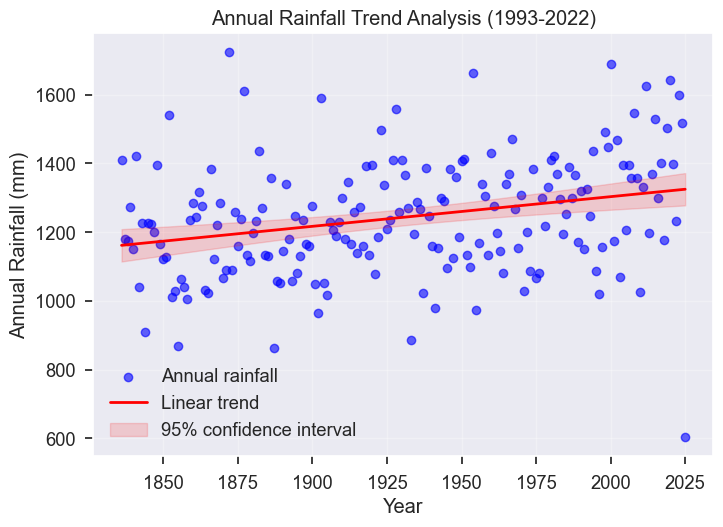

In [94]:
# Plot the results
plt.scatter(X, y, color='blue', alpha=0.6, label='Annual rainfall')
plt.plot(X, y_pred, color='red', linewidth=2, label='Linear trend')
plt.fill_between(X.flatten(), (y_pred - ci).flatten(), (y_pred + ci).flatten(), 
                 color='red', alpha=0.15, label='95% confidence interval')
plt.title('Annual Rainfall Trend Analysis (1993-2022)')
plt.xlabel('Year')
plt.ylabel('Annual Rainfall (mm)')
plt.grid(True, alpha=0.3)
plt.legend();

### 4.4 Hypothesis test

We can extract the slope value, calculate the standard error, create a t-statistic metric with a degrees of freedom (n-2).

In [95]:
# Hypothesis testing for the slope
slope = model.coef_[0]
# Calculate the intercept
intercept = model.intercept_

# Calculate standard error of the slope
x_mean = np.mean(X)
x_var = np.sum((X - x_mean)**2)
std_err = s_err / np.sqrt(x_var)

# t-test for slope. Test metric is t-statistic
t_stat = slope / std_err
# Degrees of freedom
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n-2))

# Print the results
print("\nHypothesis Testing Results:")
print(f"Linear model: Rainfall = {slope:.2f} * Year + {intercept:.2f}")
print(f"Slope: {slope:.2f} mm/year")
print(f"Standard error: {std_err:.2f}")
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.4f}")
print(f"95% confidence interval for slope: [{slope - t_val*std_err:.2f}, {slope + t_val*std_err:.2f}]")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    conclusion = "We reject the null hypothesis - there is a significant trend in rainfall."
else:
    conclusion = "We fail to reject the null hypothesis - there is no significant trend in rainfall."
print(conclusion)


Hypothesis Testing Results:
Linear model: Rainfall = 0.86 * Year + -423.56
Slope: 0.86 mm/year
Standard error: 0.22
t-statistic: 3.95
p-value: 0.0001
95% confidence interval for slope: [0.43, 1.29]
We reject the null hypothesis - there is a significant trend in rainfall.


## 5. Goodness of fit tests

While we've earlier looked at which model "looks" best, we can do a more formal goodness of fit test by comparing the distributions between the data and a best fit model.

This can take the form of a chi-squared test, KS test etc.

### 5.1 Setup

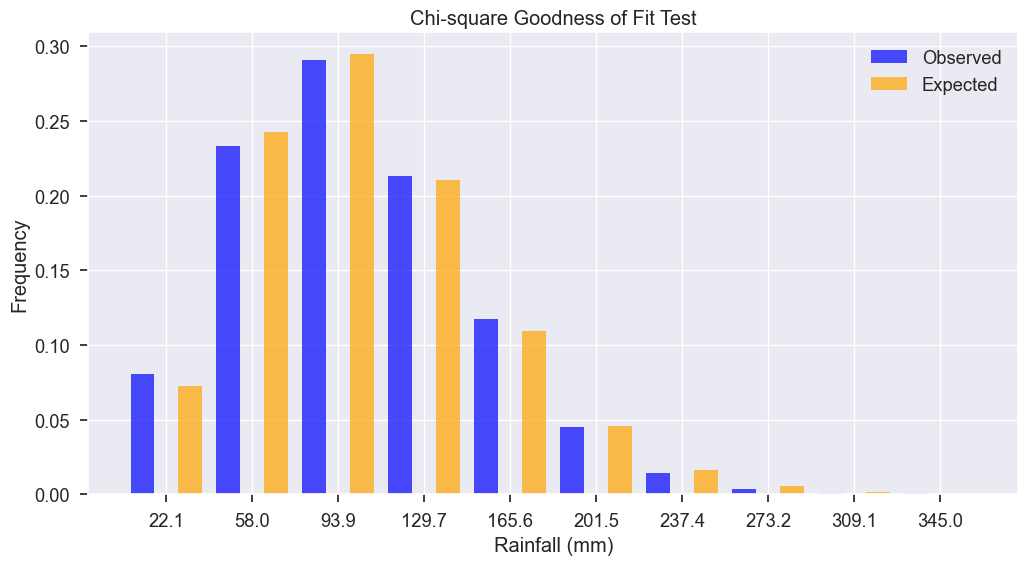

In [96]:
best_dist = distributions[best_dist_idx]
best_params = dist_params[best_dist_idx]

# Create bins and observed frequencies
hist, bin_edges = np.histogram(rainfall_data, bins=10)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
observed = hist

# Expected frequencies under the fitted distribution
cdf_low = best_dist.cdf(bin_edges[:-1], *best_params[:-2], loc=best_params[-2], scale=best_params[-1])
cdf_high = best_dist.cdf(bin_edges[1:], *best_params[:-2], loc=best_params[-2], scale=best_params[-1])
expected = (cdf_high - cdf_low) * len(rainfall_data)

# Normalize observed and expected frequencies
observed = observed / np.sum(observed)
expected = expected / np.sum(expected)


# Plot observed vs expected frequencies as side-by-side bar plots
plt.figure(figsize=(12, 6))
plt.bar(bin_centers - 10, observed, width=10, label='Observed', alpha=0.7, color='blue')
plt.bar(bin_centers + 10, expected, width=10, label='Expected', alpha=0.7, color='orange')
plt.title('Chi-square Goodness of Fit Test')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Frequency')
plt.xticks(bin_centers)
plt.legend()

### 5.2 Chi-Squared Test

In [97]:

# Chi-square statistic
chi2_stat, p_value = stats.chisquare(observed, expected)

print("\nChi-square Goodness of Fit Test:")
print(f"Chi-square statistic: {chi2_stat:.2f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print(f"The {dist_names[best_dist_idx]} distribution is not a good fit (reject H0)")
else:
    print(f"The {dist_names[best_dist_idx]} distribution is a good fit (fail to reject H0)")


Chi-square Goodness of Fit Test:
Chi-square statistic: 0.00
p-value: 1.0000
The Gamma distribution is a good fit (fail to reject H0)


### 5.3 KS-Test

In [98]:
# KS test
ks_stat, ks_p_value = stats.kstest(rainfall_data, best_dist.cdf, args=best_params)

print("\nKolmogorov-Smirnov Test:")
print(f"KS statistic: {ks_stat:.4f}")
print(f"p-value: {ks_p_value:.4f}")

if ks_p_value < 0.05:
    print(f"The {dist_names[best_dist_idx]} distribution is not a good fit (reject H0)")
else:
    print(f"The {dist_names[best_dist_idx]} distribution is a good fit (fail to reject H0)")



Kolmogorov-Smirnov Test:
KS statistic: 0.0167
p-value: 0.5436
The Gamma distribution is a good fit (fail to reject H0)


## 6. Prediction Intervals

We can try and use the model we've chosen to generate values for what might be expected to be an "outlier" event - in other words, a 1 in 20 or 1 in 100 month event. This kind of calculation is extremely useful for understanding what to prepare for as an unusual but predictable event.

### 6.1 Predicting extreme events

In [99]:
# Calculate the 95th percentile (1-in-20 month event)
percentile_95 = np.percentile(rainfall_data, 95)
print(f"\n95th percentile of rainfall: {percentile_95:.2f} mm")

# Estimate the 99th percentile (1-in-100 month event)
best_dist = distributions[best_dist_idx]
params = dist_params[best_dist_idx]
percentile_99_theory = best_dist.ppf(0.99, *params[:-2], loc=params[-2], scale=params[-1])
print(f"Estimated 99th percentile (1-in-100 month event): {percentile_99_theory:.2f} mm")


95th percentile of rainfall: 192.34 mm
Estimated 99th percentile (1-in-100 month event): 246.88 mm


### 6.2 Predicting future rainfall with confidence intervals

We can try to generate expectations for future rainfall, with confidence intervals. This is aking to generating horozontal confidence bands - using a known distribution.


Rainfall Predictions for Future Years:
Year 2023: 1323.33 mm [994.40, 1652.26]
Year 2024: 1324.19 mm [995.21, 1653.17]
Year 2025: 1325.06 mm [996.02, 1654.09]
Year 2026: 1325.92 mm [996.83, 1655.01]
Year 2027: 1326.78 mm [997.64, 1655.92]


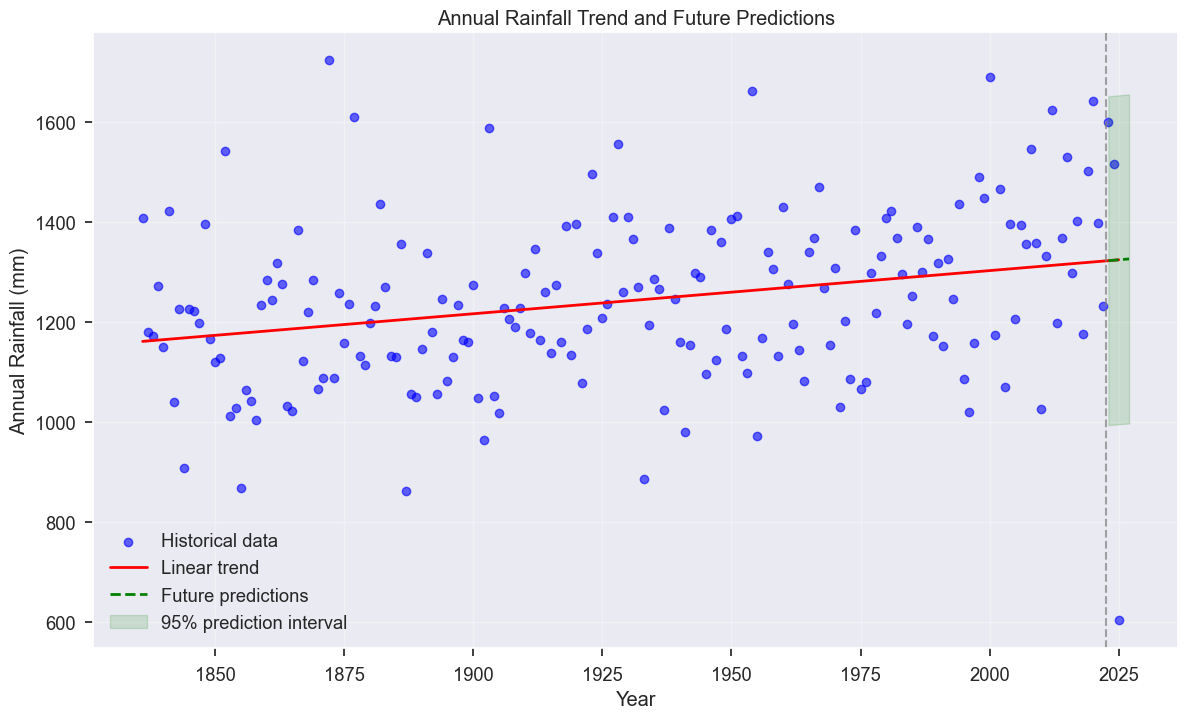

In [100]:

# Let's forecast for the next 5 years (2023-2027)
future_years = np.arange(2023, 2028).reshape(-1, 1)

# Predict with the linear model
future_predictions = model.predict(future_years)

# Calculate prediction intervals
# For prediction interval we need to add the variance of the error term
pred_se = s_err * np.sqrt(1 + 1/n + (future_years - np.mean(X))**2 / np.sum((X - np.mean(X))**2))
pred_ci = t_val * pred_se
# Transpose the CI to match the shape of future_predictions
pred_ci = pred_ci.reshape(-1, 1).squeeze()

# Plot with historical data and predictions
plt.figure(figsize=(14, 8))
plt.scatter(X, y, color='blue', alpha=0.6, label='Historical data')
plt.plot(X, y_pred, color='red', linewidth=2, label='Linear trend')

# Plot the predictions
plt.plot(future_years, future_predictions, color='green', linestyle='--', 
         linewidth=2, label='Future predictions')
plt.fill_between(future_years.flatten(), 
                 (future_predictions - pred_ci).flatten(), 
                 (future_predictions + pred_ci).flatten(), 
                 color='green', alpha=0.15, label='95% prediction interval')

plt.title('Annual Rainfall Trend and Future Predictions')
plt.xlabel('Year')
plt.ylabel('Annual Rainfall (mm)')
plt.axvline(x=2022.5, color='gray', linestyle='--', alpha=0.7)
plt.grid(True, alpha=0.3)
plt.legend()

print("\nRainfall Predictions for Future Years:")
for i, year in enumerate(future_years.flatten()):
    print(f"Year {int(year)}: {future_predictions[i]:.2f} mm [{future_predictions[i]-pred_ci[i]:.2f}, {future_predictions[i]+pred_ci[i]:.2f}]")